In [1]:
from sklearn.model_selection import train_test_split

import os
import pandas as pd

# classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import sys
sys.path.insert(0, '../')

from TextLabeller import *

%matplotlib inline

In [2]:
from plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


In [3]:
def classify(x, y, train_test_ratio):

    x_train, test, train_labels, test_labels = train_test_split(x, y, test_size = train_test_ratio)

    print('input dimensions:', len(x), '|', 'output dimensions:', len(y))
    print('x_train dimensions:', len(x_train), '|', 'y_train dimensions:', len(train_labels))
    print('x_test dimensions:', len(test), '|', 'y_test dimensions:', len(test_labels)) 

    # Initialize classifier
    rfc = RandomForestClassifier()

    # Train classifier
    model = rfc.fit(x_train, train_labels)

    # Make predictions
    y_preds = rfc.predict(test)

    # Evaluate model
    print(classification_report(test_labels, y_preds))
    print(accuracy_score(test_labels, y_preds))
    print(confusion_matrix(test_labels, y_preds))
    
    return test_labels, y_preds


# ROC Curve
def plot_roc_curve(test_labels, y_preds):
    fpr, tpr, threshold = roc_curve(test_labels, y_preds)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [4]:
METRIC = "jaccard"

labelled_real=f'{METRIC}_labelled_real_text.csv'
labelled_fake=f'{METRIC}_labelled_fake_text.csv'

real_data = pd.read_csv(labelled_real)
fake_data = pd.read_csv(labelled_fake)

combined_data = real_data.append(fake_data)

y = combined_data['label'].values

## Classify using both novelty and diversity

input dimensions: 21554 | output dimensions: 21554
x_train dimensions: 17243 | y_train dimensions: 17243
x_test dimensions: 4311 | y_test dimensions: 4311
             precision    recall  f1-score   support

          0       0.92      0.92      0.92      2187
          1       0.92      0.92      0.92      2124

avg / total       0.92      0.92      0.92      4311

0.9209000231964741
[[2013  174]
 [ 167 1957]]


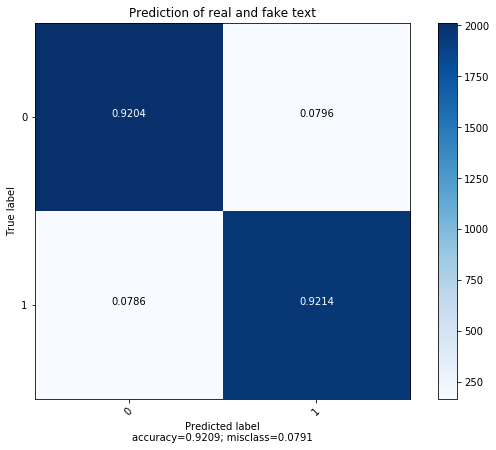

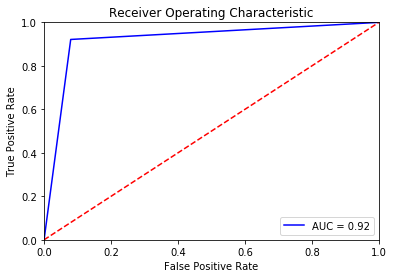

In [5]:
novs = combined_data['novelty'].values
divs = combined_data['diversity'].values

x = list()
for ix, nov in enumerate(novs):
    x.append([nov, divs[ix]])

test_labels, y_preds = classify(x, y, 0.2)

plot_confusion_matrix(cm           = confusion_matrix(test_labels, y_preds), # confusion matrix created by sklearn.metrics.confusion_matrix
                      normalize    = True,                # show proportions
                      target_names = [0, 1],       # list of names of the classes
                      title        = 'Prediction of real and fake text') # title of graph
    
plot_roc_curve(test_labels=test_labels, y_preds=y_preds)

## Classify using only novelty

input dimensions: 21554 | output dimensions: 21554
x_train dimensions: 17243 | y_train dimensions: 17243
x_test dimensions: 4311 | y_test dimensions: 4311
             precision    recall  f1-score   support

          0       0.64      0.75      0.69      2111
          1       0.71      0.59      0.65      2200

avg / total       0.68      0.67      0.67      4311

0.670610067269775
[[1593  518]
 [ 902 1298]]


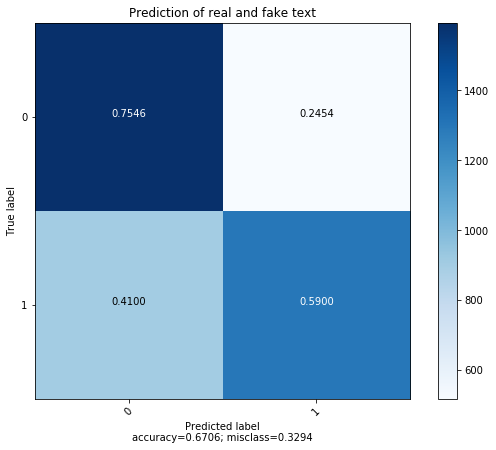

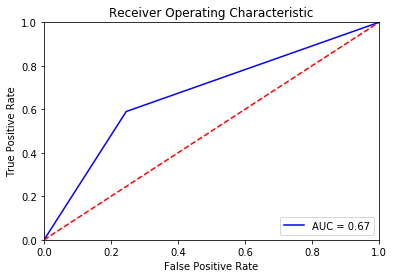

In [6]:
novs = combined_data['novelty'].values

x = list()
for ix, nov in enumerate(novs):
    x.append([nov])

test_labels, y_preds = classify(x, y, 0.2)

plot_confusion_matrix(cm           = confusion_matrix(test_labels, y_preds), # confusion matrix created by sklearn.metrics.confusion_matrix
                      normalize    = True,                # show proportions
                      target_names = [0, 1],       # list of names of the classes
                      title        = 'Prediction of real and fake text') # title of graph
    
plot_roc_curve(test_labels=test_labels, y_preds=y_preds)

## Classify using only diversity

input dimensions: 21554 | output dimensions: 21554
x_train dimensions: 17243 | y_train dimensions: 17243
x_test dimensions: 4311 | y_test dimensions: 4311
             precision    recall  f1-score   support

          0       0.84      0.91      0.87      2140
          1       0.90      0.83      0.87      2171

avg / total       0.87      0.87      0.87      4311

0.8698677800974252
[[1938  202]
 [ 359 1812]]


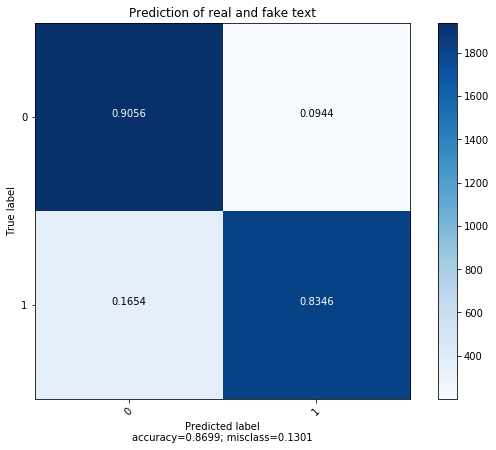

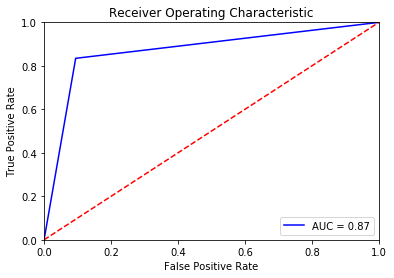

In [7]:
divs = combined_data['diversity'].values

x = list()
for ix, div in enumerate(divs):
    x.append([div])

test_labels, y_preds = classify(x, y, train_test_ratio=0.2)

plot_confusion_matrix(cm           = confusion_matrix(test_labels, y_preds), # confusion matrix created by sklearn.metrics.confusion_matrix
                      normalize    = True,                # show proportions
                      target_names = [0, 1],       # list of names of the classes
                      title        = 'Prediction of real and fake text') # title of graph
    
plot_roc_curve(test_labels=test_labels, y_preds=y_preds)

## Classify with both novelty and diversity: test with unseen data (TBD)

In [8]:
# novs = combined_data['novelty'].values
# divs = combined_data['diversity'].values

# x = list()
# for ix, nov in enumerate(novs):
#     x.append([nov, divs[ix]])
    
# # unlabelled_real='unlabelled_real_text.csv' # not really unlabelled, just missing novelty and diversity
# # unlabelled_fake='unlabelled_fake_text.csv' # same here

# # _real_data = pd.read_csv(unlabelled_real)
# # _fake_data = pd.read_csv(unlabelled_real)

# # _combined_data = _real_data.append(_fake_data)

# # x_train, test, train_labels, test_labels = x,  , y, _combined_data['label'].values

# x_train, test, train_labels, test_labels = train_test_split(x, y, test_size = 0.10)

# print('input dimensions:', len(x), '|', 'output dimensions:', len(y))
# print('x_train dimensions:', len(x_train), '|', 'y_train dimensions:', len(train_labels))
# print('x_test dimensions:', len(test), '|', 'y_test dimensions:', len(test_labels)) 

# # Initialize classifier
# rfc = RandomForestClassifier()

# # Train classifier
# model = rfc.fit(x_train, train_labels)

# # Make predictions
# preds = rfc.predict(test)

# # Evaluate model
# from sklearn.metrics import classification_report, accuracy_score
# print(classification_report(test_labels, preds))
# print(accuracy_score(test_labels, preds))